# Forecasting using Time Series Analysis


Overview:
    As part this project, we will forecast the future values of a variable using the Time based data. This is called Time Series Analysis. Various Machine Leanring Algorithms are available, ranging from Simple Moving Average, Weighted Moving Average, Holt-Winters to ARIMA, SARIMA and SARIMAX.
   
   In order to forecast the future data from the existing historical data, we need to accurately understand the Seasonaliyt, Cycle and Trend of the data. This will help us to incorporate this info into the forecasting models and predict the future more accurately.  

Dataset: The dataset consists of number of daily visitors/customers to each of the 4 restaurants along with holiday info for each day. We need to predict the number of customers for few days in to the future.

# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
import os

In [4]:
os.getcwd()

'C:\\Users\\85033964\\Documents\\Personal\\DataScience\\Python\\TimeSeries'

# Reading the input dataset

In [72]:
originaldf=pd.read_csv('RestaurantVisitors.csv')

In [73]:
originaldf = originaldf.set_index('date')

In [74]:
originaldf.index=pd.to_datetime(originaldf.index)

In [75]:
originaldf.index.freq='D'

In [10]:
df=pd.read_csv('C:\\Users\\85033964\\Documents\\Personal\\DataScience\\Python\\TimeSeries\\RestaurantVisitors.csv')

Setting the Index to Date column of the dataset

In [12]:
df = df.set_index('date')

Checking the data by random sampling of 10 observations

In [13]:
df.sample(10)

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
8/27/2016,Saturday,0,na,55.0,31.0,61.0,49.0,196.0
3/26/2016,Saturday,0,na,78.0,46.0,59.0,109.0,292.0
5/19/2016,Thursday,0,na,32.0,10.0,12.0,23.0,77.0
2/5/2016,Friday,0,na,56.0,56.0,24.0,11.0,147.0
4/1/2016,Friday,0,na,36.0,46.0,24.0,19.0,125.0
3/17/2016,Thursday,1,St. Patrick's Day,67.0,22.0,65.0,55.0,209.0
1/10/2016,Sunday,0,na,26.0,43.0,49.0,94.0,212.0
5/25/2016,Wednesday,0,na,24.0,42.0,30.0,27.0,123.0
3/18/2017,Saturday,0,na,71.0,34.0,30.0,44.0,179.0


In [14]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
1/1/2016,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
1/2/2016,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
1/3/2016,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
1/4/2016,Monday,0,na,23.0,18.0,32.0,32.0,105.0
1/5/2016,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [15]:
df.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [17]:
df.index=pd.to_datetime(df.index)

In [18]:
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='date', length=517, freq=None)

As can be from the above index output, the frequency is set to None and as it is a Daily data, we will set it to 'D' as datatime alias

In [19]:
df.index.freq='D'

In [20]:
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='date', length=517, freq='D')

Checking the dataset features and their types:


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 517 entries, 2016-01-01 to 2017-05-31
Freq: D
Data columns (total 8 columns):
weekday         517 non-null object
holiday         517 non-null int64
holiday_name    517 non-null object
rest1           478 non-null float64
rest2           478 non-null float64
rest3           478 non-null float64
rest4           478 non-null float64
total           478 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 36.4+ KB


Checking for any Null/NA values

In [24]:
df.isnull().sum()

weekday          0
holiday          0
holiday_name     0
rest1           39
rest2           39
rest3           39
rest4           39
total           39
dtype: int64

As can be seen there are 39 observations with Null values for 4 restaurant columns, so we will consider them as test set for predictions/forecasts. For now, we will drop them for building the model

In [25]:
df.dropna(inplace=True)

Converting Float values of Restaurant features to Integer as customer numbers with float type does not make sense

In [27]:
cols = ['rest1', 'rest2', 'rest3','rest4', 'total']
for column in cols:
    df[column] = df[column].astype(int)

Plotting the Total feature

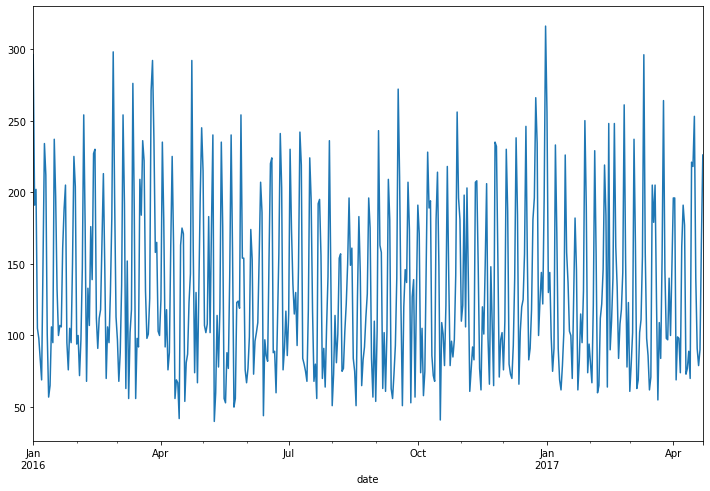

In [28]:
df['total'].plot(figsize=(12,8))

The above plot shows few spikes, which could be due to holidays, weekends, etc. where the restaurants see more number of customers

Lets mark where the holidays are, as per the given data.

In [30]:
df[df['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

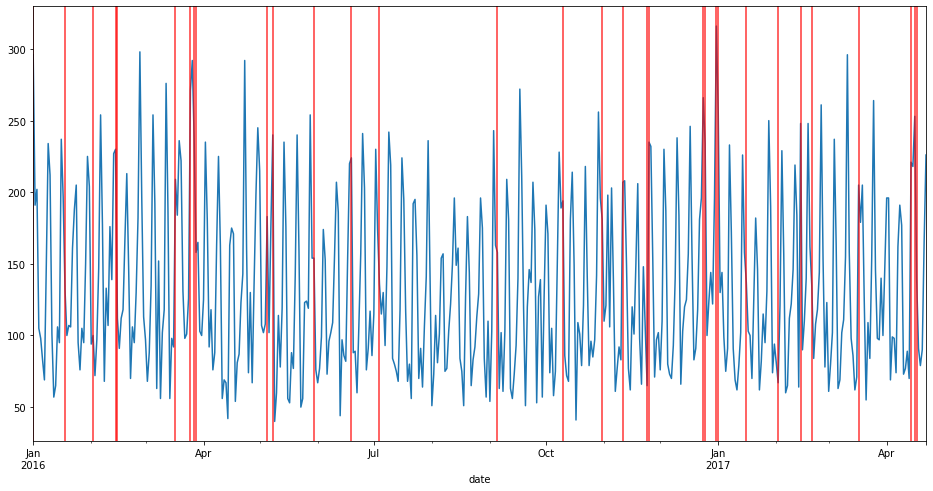

In [31]:
ax = df['total'].plot(figsize=(16,8))
for day in df[df['holiday']==1].index:
    ax.axvline(x=day,color='red',alpha=0.8);

Checking for Seasonality

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


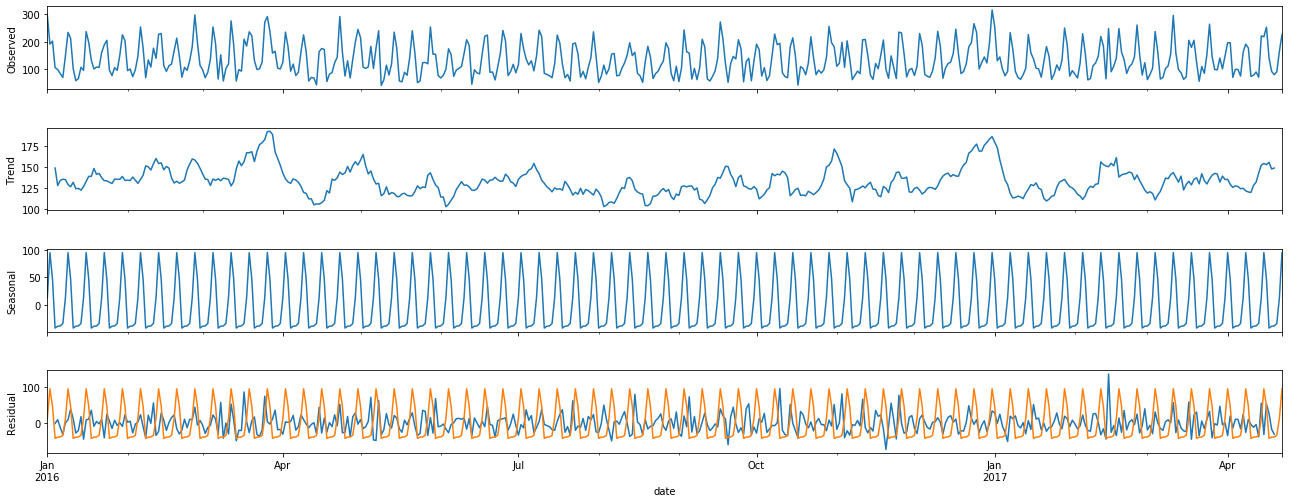

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
result= seasonal_decompose(df['total'], model='additive')
result.plot();
result.seasonal.plot(figsize=(20,8));

As per the 3rd plot in the above figure, there is clear Seasonality in the data

# Model Fitting

In [33]:
len(df)
train=df.iloc[:448]
test = df.iloc[448:]
start=len(train)
end=len(train)+len(test)-1

In [38]:
len(df)

478

In [34]:
train

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98
...,...,...,...,...,...,...,...,...
2017-03-19,Sunday,0,na,33,25,68,79,205
2017-03-20,Monday,0,na,34,22,19,50,125
2017-03-21,Tuesday,0,na,4,18,15,18,55


In [36]:
test.shape

(30, 8)

In [39]:
end

477

In [41]:
from pmdarima import auto_arima

C:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [42]:
auto_arima(df['total'],seasonal=True,m=7).summary()  #m=7 as it has weekly Seasonality

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Wed, 11 Mar 2020   AIC                           4845.442
Time:                                   12:42:47   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5664      4.363      4.714      0.000      12.015      29.118
ar.L1          0.1897      0.045      4.221      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.4026     86.679     16.468      0.000    1257.514    1597.291
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As per the above model statistics, the model suggested is:  SARIMAX(1, 0, 0)x(2, 0, 0, 7)

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
model=SARIMAX(train['total'],order=(1, 0, 0),seasonal_order=(2, 0, 0, 7)).fit()

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  448
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2288.203
Date:                           Wed, 11 Mar 2020   AIC                           4584.406
Time:                                   12:45:01   BIC                           4600.826
Sample:                               01-01-2016   HQIC                          4590.879
                                    - 03-23-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1973      0.046      4.281      0.000       0.107       0.288
ar.S.L7        0.5053      0.036     14.158      0.000       0.435       0.575
ar.S.L14       0.4593      0.037     12.391      0.000       0.387       0.532
sigma2      1536.8928     82.553     18.617      0.000    1375.091    1698.695
===================================================================================
Ljung-Box (Q):                       87.10   Jarque-Bera (JB):                27.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.31
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecasts without use of Exogenous variable

In [48]:
predictions =model.predict(start=start, end=end ).rename('SARIMA predictions')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [49]:
predictions

2017-03-24    174.216960
2017-03-25    226.295672
2017-03-26    176.137338
2017-03-27    108.171670
2017-03-28     67.292063
2017-03-29     83.555588
2017-03-30     75.056964
2017-03-31    182.192360
2017-04-01    196.565737
2017-04-02    183.162741
2017-04-03    112.074114
2017-04-04     59.265348
2017-04-05     92.286447
2017-04-06     76.509153
2017-04-07    172.083222
2017-04-08    203.266743
2017-04-09    173.455621
2017-04-10    106.316512
2017-04-11     60.855359
2017-04-12     85.011157
2017-04-13     73.135270
2017-04-14    170.638263
2017-04-15    192.997350
2017-04-16    171.777453
2017-04-17    105.199627
2017-04-18     57.971998
2017-04-19     85.345148
2017-04-20     72.097446
2017-04-21    165.264829
2017-04-22    190.886063
Freq: D, Name: SARIMA predictions, dtype: float64

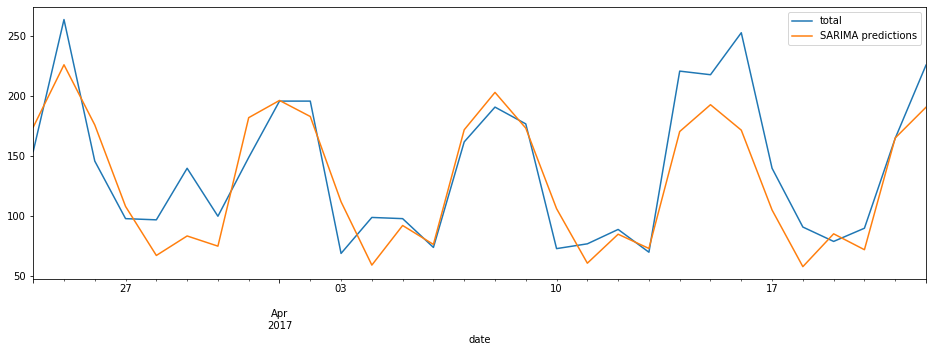

In [50]:
test['total'].plot(figsize=(16,5),legend=True)
predictions.plot(legend=True)

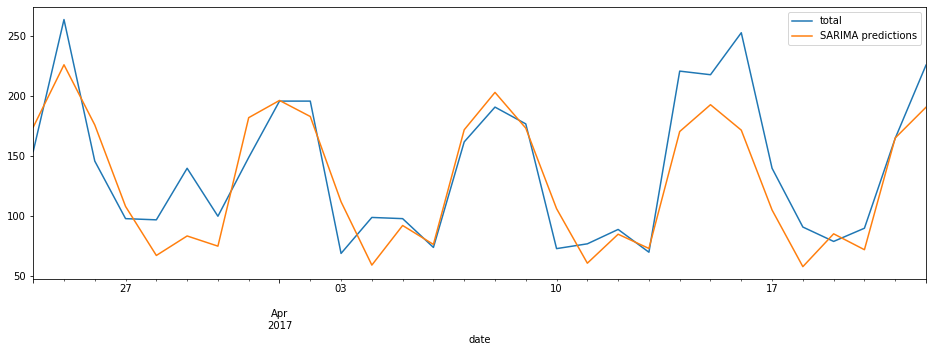

In [51]:
ax = test['total'].plot(figsize=(16,5),legend=True)
predictions.plot(legend=True)

In [52]:
for day in test.query('holiday==1').index:
    ax.axvline(x=day,color='red',alpha=0.8);

Root Mean Square Error (RMSE)

In [55]:
from statsmodels.tools.eval_measures import rmse

In [56]:
print(rmse(test['total'],predictions)) #30.3249757971

30.324975797142375


In [57]:
print(test['total'].mean())

140.06666666666666


As the rmse value of test dataset is lower compared to mean of the test set, it is OK

# Now building the Model using Exogenous Variable

Building the model to find the best ARIMA model statistics

In [58]:
auto_arima(df['total'],exogenous=df[['holiday']],m=7, seasonal=True).summary()

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2348.691
Date:                           Wed, 11 Mar 2020   AIC                           4709.381
Time:                                   14:02:03   BIC                           4734.399
Sample:                                        0   HQIC                          4719.217
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.5647      4.273      2.706      0.007       3.190      19.940
x1            74.8568      4.547     16.463      0.000      65.945      83.769
ma.L1          0.1782      0.051      3.474      0.001       0.078       0.279
ar.S.L7        0.5057      0.045     11.224      0.000       0.417       0.594
ar.S.L14       0.3842      0.043      8.978      0.000       0.300       0.468
sigma2      1142.1965     80.213     14.240      0.000     984.982    1299.411
===================================================================================
Ljung-Box (Q):                       85.00   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               0.89   Skew:                             0.12
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model:
SARIMAX(0, 0, 1)x(2, 0, 0, 7)

# Now Building the SARIMAX model

In [60]:
#Training our SARIMAX
model = SARIMAX(train['total'],exog=train[['holiday']],order=(0,0,1), seasonal_order=(2,0,0,7)).fit()

In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  448
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2219.465
Date:                           Wed, 11 Mar 2020   AIC                           4448.930
Time:                                   14:03:50   BIC                           4469.454
Sample:                               01-01-2016   HQIC                          4457.021
                                    - 03-23-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.7546      4.295     16.009      0.000      60.337      77.172
ma.L1          0.1933      0.049      3.984      0.000       0.098       0.288
ar.S.L7        0.5060      0.041     12.322      0.000       0.425       0.586
ar.S.L14       0.4678      0.041     11.400      0.000       0.387       0.548
sigma2      1125.5778     72.632     15.497      0.000     983.221    1267.935
===================================================================================
Ljung-Box (Q):                      100.07   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.00   Prob(JB):                         0.60
Heteroskedasticity (H):               0.95   Skew:                             0.09
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
start=len(train)
end=len(train)+len(test)-1

In [63]:
predictions= model.predict(start=start,end=end,exog=test[['holiday']]).rename('SARIMAX-Exogenous')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


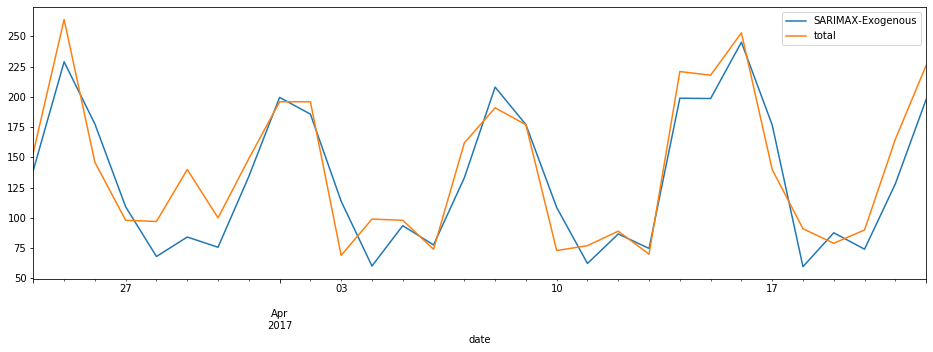

In [64]:
predictions.plot(figsize=(16,5),legend=True)
test['total'].plot(legend=True)

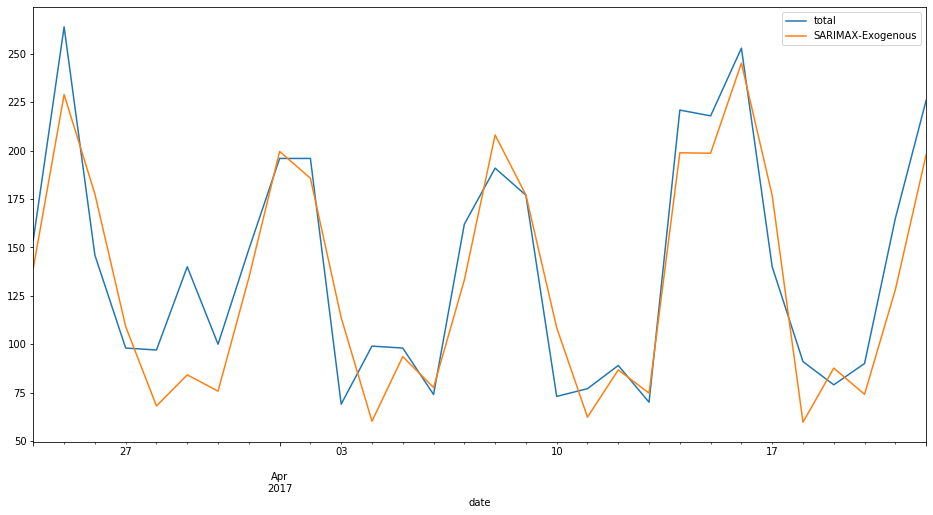

In [65]:
ax = test['total'].plot(figsize=(16,8),legend=True)
predictions.plot(legend=True)

In [66]:
for day in test.query('holiday==1').index:
    ax.axvline(x=day,color='red',alpha=0.8);

In [67]:
rmse(test['total'],predictions) 

25.39431789007517

The RMSE value has decreased fro 30 to 25 when Exogenous variable is used for building the model

# Now fitting the model to full dataset 

In [69]:
model =  SARIMAX(df['total'],exog=df[['holiday']],order=(0,0,1), seasonal_order=(2,0,0,7)).fit()

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  478
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2359.765
Date:                           Wed, 11 Mar 2020   AIC                           4729.529
Time:                                   14:06:17   BIC                           4750.377
Sample:                               01-01-2016   HQIC                          4737.726
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.3552      4.154     16.457      0.000      60.214      76.496
ma.L1          0.1848      0.047      3.959      0.000       0.093       0.276
ar.S.L7        0.5033      0.039     13.053      0.000       0.428       0.579
ar.S.L14       0.4718      0.038     12.265      0.000       0.396       0.547
sigma2      1089.2217     67.396     16.162      0.000     957.128    1221.315
===================================================================================
Ljung-Box (Q):                      106.41   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               0.85   Skew:                             0.08
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
exg_forecast = originaldf[478:][['holiday']]

In [76]:
forecasts = model.predict(start=len(df), end=len(df)+38,exog=exg_forecast).rename('final SARIMAX forecasts')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


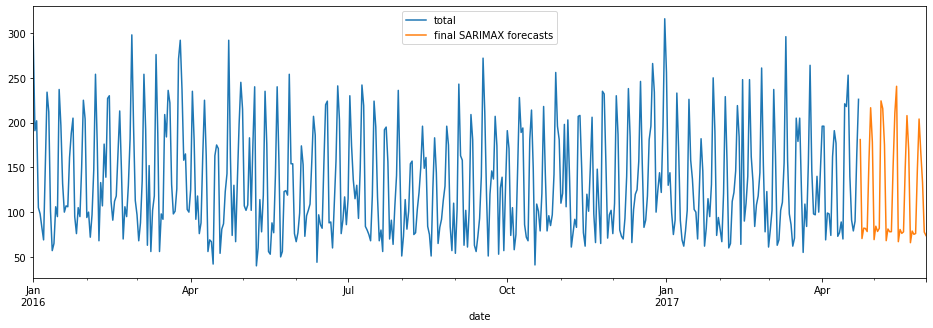

In [77]:
df['total'].plot(figsize=(16,5),legend=True)
forecasts.plot(legend=True)

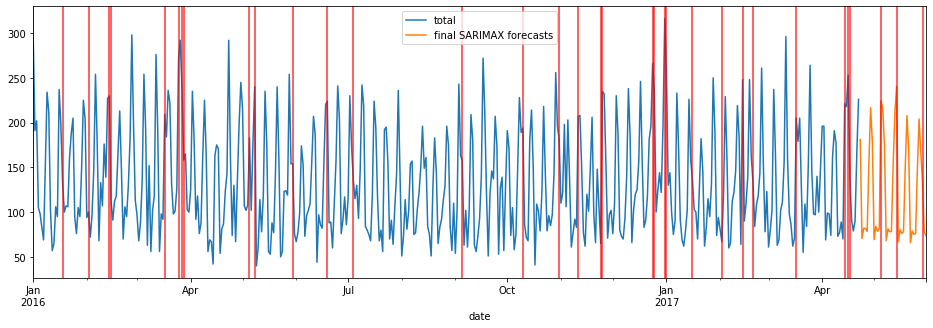

In [78]:
ax=df['total'].plot(figsize=(16,5),legend=True)
forecasts.plot(legend=True)
for day in originaldf.query('holiday==1').index:
    ax.axvline(x=day,color='red',alpha=0.8);